In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import seaborn as sns
from wordcloud import WordCloud
import time
import copy
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchtext import data
from torchtext.vocab import Vectors, GloVe
from torchtext.legacy.data import Field

ModuleNotFoundError: No module named 'torchtext.legacy'

### 6.5.1 文本数据预处理与探索

In [6]:
# 定义读取训练数据和测试数据的函数
def load_text_data(path):
    # 获取文件夹的最后一个字段
    text_data = []
    label = []
    for dset in ["pos", "neg"]:
        path_dset = os.path.join(path, dset)
        path_list = os.listdir(path_dset)
        # 读取文件夹下的pos或neg文件
        for fname in path_list:
            if fname.endswith(".txt"):
                filename = os.path.join(path_dset, fname)
                with open(filename, "r", encoding="utf-8") as f:
                    text_data.append(f.read())
            if dset == "pos":
                label.append(1)
            else:
                label.append(0)
    # 输出读取的文本和对应的标签
    return np.array(text_data), np.array(label)
# 读取训练集和测试集
train_path = "D:/Data/PytorchSDXXRMYSJ/chap6/imdb/train"
train_text, train_label = load_text_data(train_path)
test_path = "D:/Data/PytorchSDXXRMYSJ/chap6/imdb/test"
test_text, test_label = load_text_data(test_path)
print(len(train_text), len(train_label))
print(len(test_text), len(test_label))

25000 25000
25000 25000


In [7]:
# 对文本数据进行预处理
def text_preprocess(text_data):
    text_pre = []
    for text1 in text_data:
        # 去除指定的字符"<br /><br />"
        text1 = re.sub("<br /><br />", " ", text1) # 去除指定字符
        # 转化为小写，去除数字，去除标点符号，去除空格
        text1 = text1.lower()
        text1 = re.sub("\d+", "", text1) # 去除数字
        text1 = text1.translate(
            str.maketrans("","", string.punctuation.replace("'", ""))
        ) # 去除标点符号
        text1 = text1.strip() # 去除多余空格
        text_pre.append(text1)
    return np.array(text_pre)
train_text_pre = text_preprocess(train_text)
test_text_pre = text_preprocess(test_text)

In [13]:
# 文本符号化处理，去除停用词
def stop_stem_word(datalist, stop_words):
    datalist_pre = []
    for text in datalist:
        text_words = word_tokenize(text)
        # 去除停用词
        text_words = [word for word in text_words if not word in stop_words]
        # 删除带有"'"的词语，如it's
        text_words = [word for word in text_words if len(re.findall("'", word))==0]
        datalist_pre.append(text_words)
    return np.array(datalist_pre)
# 文本符号化处理，去除停用词
stop_words = stopwords.words("english")
stop_words = set(stop_words)
train_text_pre2 = stop_stem_word(train_text_pre, stop_words)
test_text_pre2 = stop_stem_word(test_text_pre, stop_words)
print(train_text_pre[10000])
print("="*10)
print(train_text_pre2[10000])

C:\Users\xinx_\AppData\Local\Temp\ipykernel_21620\2465627006.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist_pre)


i really liked tom barman's awtwb you just have to let it come over you and enjoy it while it lasts and don't expect anything it's like sitting on a caféterrace with a beer in the summer sun and watching the people go by it definitely won't keep you pondering afterwards that's true but that's not a prerequisite for a good film it's just the experience during the movie that's great i felt there were a few strands that could have been worked out a little more but being a lynch fan i don't care that much anymore  and i loved the style or flair of this movie it's slick but fresh and the soundtrack is a beauty any musiclover will get his kicks out of awtwb i can assure you i'll give it  out  musicwise  out of
['really', 'liked', 'tom', 'barman', 'awtwb', 'let', 'come', 'enjoy', 'lasts', 'expect', 'anything', 'like', 'sitting', 'caféterrace', 'beer', 'summer', 'sun', 'watching', 'people', 'go', 'definitely', 'wo', 'keep', 'pondering', 'afterwards', 'true', 'prerequisite', 'good', 'film', 'ex

In [15]:
# 将处理好的文本保存到csv文件中
texts = [" ".join(words) for words in train_text_pre2]
traindatasave = pd.DataFrame({"text":texts,
                              "label":train_label})
texts = [" ".join(words) for words in test_text_pre2]
testdatasave = pd.DataFrame({"text":texts,
                             "label":test_label})
traindatasave.to_csv("imdb_train.csv", index=False)
testdatasave.to_csv("imdb_test.csv", index=False)

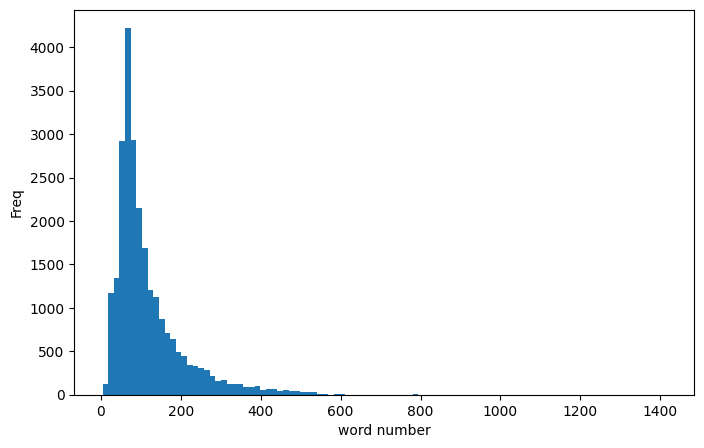

In [16]:
# 将预处理好的文本数据转化为数据表
traindata = pd.DataFrame({"train_text":train_text, "train_word":train_text_pre2, "train_label":train_label})
# 计算每个影评中词的数量
train_word_num = [len(text) for text in train_text_pre2]
traindata["train_word_num"] = train_word_num
# 可视化影评长度的分布
plt.figure(figsize=(8, 5))
_ = plt.hist(train_word_num, bins=100)
plt.xlabel("word number")
plt.ylabel("Freq")
plt.show()

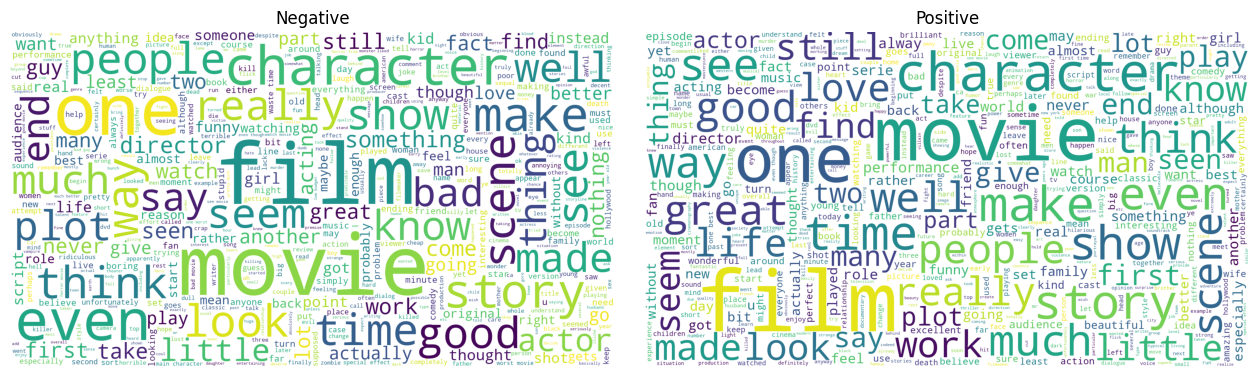

In [20]:
# 使用词云可视化两种情感的词频差异
plt.figure(figsize=(16, 10))
for ii in np.unique(train_label):
    # 准备每种情感的所有词语
    text = np.array(traindata.train_word[traindata.train_label == ii])
    text = " ".join(np.concatenate(text))
    plt.subplot(1, 2, ii+1)
    # 生成词云
    wordcod = WordCloud(margin=5, width=1800, height=1000, max_words=500, min_font_size=5, background_color='white', max_font_size=250)
    wordcod.generate_from_text(text)
    plt.imshow(wordcod)
    plt.axis("off")
    if ii == 1:
        plt.title("Positive")
    else:
        plt.title("Negative")
    plt.subplots_adjust(wspace=0.05)
plt.show()

### 6.5.2 TextCNN网络的建立和预测

#### 1.数据准备

In [21]:
# 使用torchtext库进行数据准备，定义文件中对文本和标签所要做的操作
# 定义文本切分方法，因为前面已经做过处理，所以直接使用空格切分即可
mytokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=mytokenize, include_lengths=True, use_vocab=True, batch_first=True, fix_length=200)
LABEL = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
# 对所要读取的数据集的列进行处理
train_test_fields = [
    ("label", LABEL), # 对标签的操作
    ("text", TEXT) # 对文本的操作
]
# 读取数据
traindata, testdata = data.TabularDataset.split(
    path="D:/GitHub/Learning/Python/PytorchSDXXRMYSJ", format="csv",
    train="imdb_train.csv", fields=train_test_fields,
    test="imdb_test.csv", skip_header=True
)
len(traindata), len(testdata)

AttributeError: module 'torchtext.data' has no attribute 'Field'